In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

# Classification of surroundings for drones


Our task is to classify surroundings of the drone given a single image. I approach the problem with 3 different sub-classification tasks: 
1. **Setting Classification:** Urban, Rural, Mountains, Forest, Shore
2. **Weather Classification:** Sunny, Cloudy, Foggy, Snowy
3. **Daytime Classification:** Daytime, Nighttime, Dusk/Dawn

Unfortunately, I didn't find any labeled data of the sun or horizon (with masks or bboxes) and I didn't want to use Hough transforms.
For daytime classification it is very difficult to differentiate between dusk, dawn, sunrise and sunset from images alone, so I assume it's one class 'dusk/dawn'.


## Datasets used:

### 1. Setting Classification Dataset: Imagenet + OpenImages
#### Imagenet
Imagenet is one of the largest datasets of human-verified images. I extracted only images by specific synset that is closest to the task given. I used [ImageNet_Utils package](https://github.com/tzutalin/ImageNet_Utils) in order to download some synsets that only containted links from flickr.com.

#### GoogleOpenImages
[GoogleOpenImages](https://github.com/openimages/dataset) dataset contains more than 20 million human-verified labels of 9 million images. Due to the format of the metadata I had to extract which images to collect based on a given class. Then I used [OpenImageDownloader package](https://github.com/ejlb/google-open-image-download) to download images given the links.
I only took *human-labeled* images that are in *trainable class* with *confidence=1*. 

In brackets is the number of images.

|            | Urban Area          | Rural Area           | Mountains  | Forest | Shore |
| --         |   -------------     |-------------         | -----      |--      | --    |
|**Imagenet**| City + Street = (2341)| Farm + Valley = (1904) |Mountain + Monocline = (2016)|Tree (1171)| Beach + Shore + Oceanfront = (4754)| 
|**OpenImages**| Cityscape (595) + Urban Area (696) | Rural Area (531) | Mountain (1508) | Forest (1862) | Shore (531) 


| Train | Validation | Test |
| ----- | -----------| -----|
| 15060 | 2880       | 23 |

### 2. Weather Classification Dataset: Image2Weather
[Image2Weather paper](http://ieeexplore.ieee.org/document/7545010/) made an attempt to classify weather condition inferred solely from an image. They have crawled flickr for images uploaded at a certain date and compiled the weather at that point in time. 
Unfortunately, their dataset is not balanced as we do have significant number of images for sunny and cloudy classes.

|            | Sunny          | Cloudy           | Foggy  |  Snowy |
| --         |   -------------|-------------     | -----      |----|
|**Image2Weather**| (7206) | (8544) | (359) | (1254) |

| Train | Validation | Test |
| ----- | -----------| -----|
| 9260  | 8116        | 29 |

### 3. Daytime Classification Dataset: OpenImages

|            | Daytime          | Nighttime           | Dusk/Dawn  | 
| --         |   -------------     |-------------     | -----      |
|**OpenImages**| Daytime (784) | Night (512) | Dusk/Dawn (380+184) | 


| Train | Validation | Test |
| ----- | -----------| -----|
| 1610  | 215        | 26 |


There were many images that were missing when downloaded, those has to be manually deleted.

#### Test set
I manually classify the given 31 images into appropriate classes for each class. Test sets are available in the repo.

## Model 

Ideally we do not want to construct, train and deploy a separate model for each different task as that would take more memory and development time. Recently, multi-task learning has been successful in deep learning models. Therefore, it is feasible to train a single model for all tasks as our tasks are correlated to a certain degree.

Additionally, transfer learning has been very successful in the past several years. We can easily take a state-of-the-art pre-trained model that learnt on Image-net and contains very useful features and fine-tune it by taking out the last layer of the network. In our case I have appended 3 different independent branches after the second last layer.

There is a problem that each dataset doesn't have a label of the task of the other dataset. E.g. Imagenet images don't have labels of the WeatherImageDataset. This is clearly a problem because when we train on Imagenet we would not be able to learn anything on Weather. I solve it by iteratively training on separate task while freezing the last layer of the other 2 tasks. E.g. when training for Weather Classification, we turn off the gradient updates for branches of other 2 tasks.

I tried architecture of Densenet-121 (7.83% top-5 error) [1] (I wanted to try Squeezenet 1.1 as it is better suit for our application but there was a problem on my server).

I append two dense layers and softmax for each task and train with cross-entropy loss.

## Training

In order to deal with large imbalance of the data we perform balanced mini-batch sampling of each class. 

I pick the initial learning rate to be 0.1 as from Densenet paper only for new weights in the appended branches. The learning rate for pre-trained weights is always scaled to be 20% of the original learning rate. After ~10 epochs we scale the learning rate down by 5. I train with 
`SGD(lr=0.1, momentum=0.9, weight_decay=1e-4)` with `batch_size=32`.

It took quite some time to experiment with multi-task training. It is crucial to take small number of weight updates for each task so that the model doesn't overfit for specific task, so I only train on 10 batches for each task and then move on to the next.

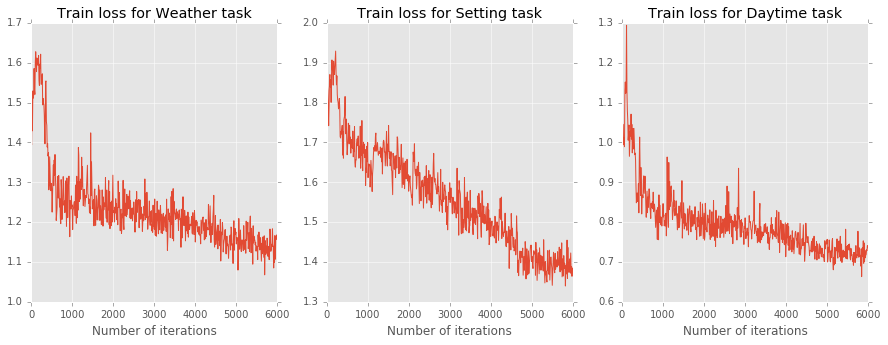

In [2]:
losses_w = np.load('losses_weather.npy')
losses_s = np.load('losses_setting.npy')
losses_d = np.load('losses_daytime.npy')

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
iters = np.arange(len(losses_w))*10
axes[0].plot(iters, losses_w)
axes[1].plot(iters, losses_s)
axes[2].plot(iters, losses_d)
axes[0].set_title("Train loss for Weather task")
axes[1].set_title("Train loss for Setting task")
axes[2].set_title("Train loss for Daytime task")
axes[0].set_xlabel("Number of iterations")
axes[1].set_xlabel("Number of iterations")
axes[2].set_xlabel("Number of iterations")

(0.0, 100.0)

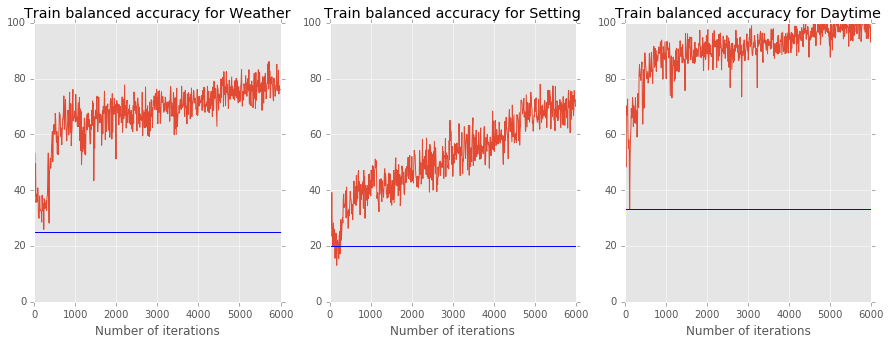

In [3]:
accs_w = np.load('accs_weather.npy')
accs_s = np.load('accs_setting.npy')
accs_d = np.load('accs_daytime.npy')

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
iters = np.arange(len(losses_w))*10
axes[0].plot(iters, accs_w)
axes[1].plot(iters, accs_s)
axes[2].plot(iters, accs_d)
axes[0].set_title("Train balanced accuracy for Weather")
axes[0].axhline(25)
axes[1].set_title("Train balanced accuracy for Setting")
axes[1].axhline(20)
axes[2].set_title("Train balanced accuracy for Daytime")
axes[2].axhline(33.33)
axes[0].set_xlabel("Number of iterations")
axes[1].set_xlabel("Number of iterations")
axes[2].set_xlabel("Number of iterations")
axes[0].set_ylim([0., 100.])
axes[1].set_ylim([0., 100.])
axes[2].set_ylim([0., 100.])

Blue line represents random prediction, i.e. uniform over classes.

In reality accuracy will be higher since labels that appear more often in the data distribution are easier to classify.

## Results
I report *balanced accuracy (where the minority classes are upsampled to make it balanced)* on train and validation set and accuracy on the test set.

|         | Train | Validation | Test |
|--- | ----- | -----------| -----|
|Setting | 70.5   | 61.9 | 36 |
|Weather | 77.1   | 61.0 | 45 |
|Daytime | 99     | 82.9 | 18 |


There are several reasons why the model didn't generalize well to the test set:
1. Training on a dataset that is from a slightly different data distribution would not generalize well.
2. Our test set metric has very large variance as there are less than 30 samples in each. 
3. The train set has a very different balance of classes wrt test set.
4. I didn't do much of hyper-parameter optimization because of time constraints.  
5. Training multi-task model while iterating the branch parameter updates is very noisy.


## References
[1] [Huang et al, (2016) Densely Connected Convolutional Networks
](https://arxiv.org/abs/1608.06993)

[2] [Chu et al, (2016) Image2Weather: A Large-Scale Image Dataset for Weather Property Estimation](http://ieeexplore.ieee.org/document/7545010/)